# lapcian fusion
[图像融合：拉普拉斯金字塔融合算法](https://www.jianshu.com/p/3185cca3f082)  
[Rachine/ExposureFusion](https://github.com/Rachine/ExposureFusion)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import pdb
import PIL
from tqdm import tqdm

# utils.py

In [3]:
import pdb
import numpy as np
import scipy.signal as sig


def kernel_1D(n, a=0.6):
    """Kernel function in 1 dimension"""
    kernel = [.0625, .25, .375, .25, .0625]
#    if n == 0:
#        return a
#    elif n == -1 or n == 1:
#        return 1./4
#    elif n == -2 or n == 2:
#        return 1./4 - float(a)/2
#    else:
#        return 0
    return kernel[n]


def kernel_old(m, n, a=0.6):
    """Returns the value of the kernel at position w and n"""
    return kernel_1D(m, a)*kernel_1D(n, a)


def get_kernel(a=0.6):
    kernel = np.zeros((5,5))
    for i in range(5):
        for j in range(5):
            kernel[i, j] = kernel_1D(i, a)*kernel_1D(j, a)
    return kernel


def Reduce_old(image, n, a=0.6):
    """Reduce function for Pyramids"""
    try:
        if n == 0:
            return image
        else:
            image = Reduce(image, n-1, a)
            [R, C] = [image.shape[0], image.shape[1]]
            image_extended = np.zeros((R+4, C+4))
            image_extended[2:R+2, 2:C+2] = image
            try:
                image_reduced = np.zeros((R/2, C/2))
            except Exception as e:
                print ("Dimension Error")
                print (e)
            
            for i in range(R/2):
                for j in range(C/2):
                    for m in range(-2, 3):
                        for n in range(-2, 3):
                            image_reduced[i, j] += kernel_old(m, n) * image_extended[2 * i + m + 2, 2 * j + n + 2]
            return image_reduced
    except Exception as e:
        print ("Dimension Error")
        print (e)


def weighted_sum(image, i, j, a):
    weighted_sum = 0
    for m in range(-2, 3):
        for n in range(-2, 3):
            pixel_i = float(i - m) / 2
            pixel_j = float(j - n) / 2
            if pixel_i.is_integer() and pixel_j.is_integer():
                weighted_sum += kernel_old(m, n, a) * image[pixel_i, pixel_j]
    return 4 * weighted_sum


def Expand_old(image, n, a=0.6):
    """Expand function for Pyramids"""
    try:
        if n == 0:
            return image
        else:
            image = Expand(image, n-1, a)
            [R, C] = image.shape
            image_extended = np.zeros((R+4, C+4))
            image_extended[2:R+2, 2:C+2] = image
            new_floor = np.zeros((2 * R, 2 * C))
            for i in range(2 * R):
                for j in range(2 * C):
                    new_floor[i, j] = weighted_sum(image_extended, i+2, j+2, a)
            new_floor = (new_floor - np.min(new_floor))
            new_floor = new_floor / np.max(new_floor)
            return new_floor                
    except Exception as e:
        print ("Dimension error")
        print (e)


def Reduce1(image, a=0.6):
    kernel = get_kernel(a)
    shape = image.shape
    if len(shape) == 3:
        image_reduced = np.zeros((shape[0]/2, shape[1]/2, 3))
        for canal in range(3):
            canal_reduced = sig.convolve2d(image[:, :, canal], kernel, 'same')
            image_reduced[:, :, canal] = canal_reduced[::2, ::2]
    else:
        image_reduced = sig.convolve2d(image, kernel, 'same')[::2, ::2]
    return image_reduced


def Reduce(image, n, a=0.6):
    """Reduce function for Pyramids"""
    #print('Reduce', n)
    try:
        if n == 0:
            return image
        else:
            image = Reduce(image, n-1, a)
            #print(image.shape)
            return Reduce1(image, a)
    except Exception as e:
        print ("Dimension Error")
        print (e)


def Expand1(image, a=0.6):
    kernel = get_kernel(a)
    shape = image.shape
    if len(shape) == 3:
        image_to_expand = np.zeros((2*shape[0], 2*shape[1], 3))
        image_expanded = np.zeros(image_to_expand.shape)
        for canal in range(3):
            # 每隔一个像素填充一次
            image_to_expand[::2, ::2, canal] = image[:, :, canal]
            image_expanded[:, :, canal] = sig.convolve2d(image_to_expand[:, :, canal], 4*kernel, 'same')
    else:
        image_to_expand = np.zeros((2 * shape[0], 2 * shape[1]))
        image_to_expand[::2, ::2] = image
        image_expanded = sig.convolve2d(image_to_expand[:, :], 4*kernel, 'same')
    return image_expanded


def Expand(image, n, a=0.6):
    """Expand function for Pyramids"""
    try:
        if n == 0:
            return image
        else:
            image = Expand(image, n-1, a)
            return Expand1(image, a)
    except Exception as e:
        print ("Expand ,Dimension error")
        print (e)


# image.py

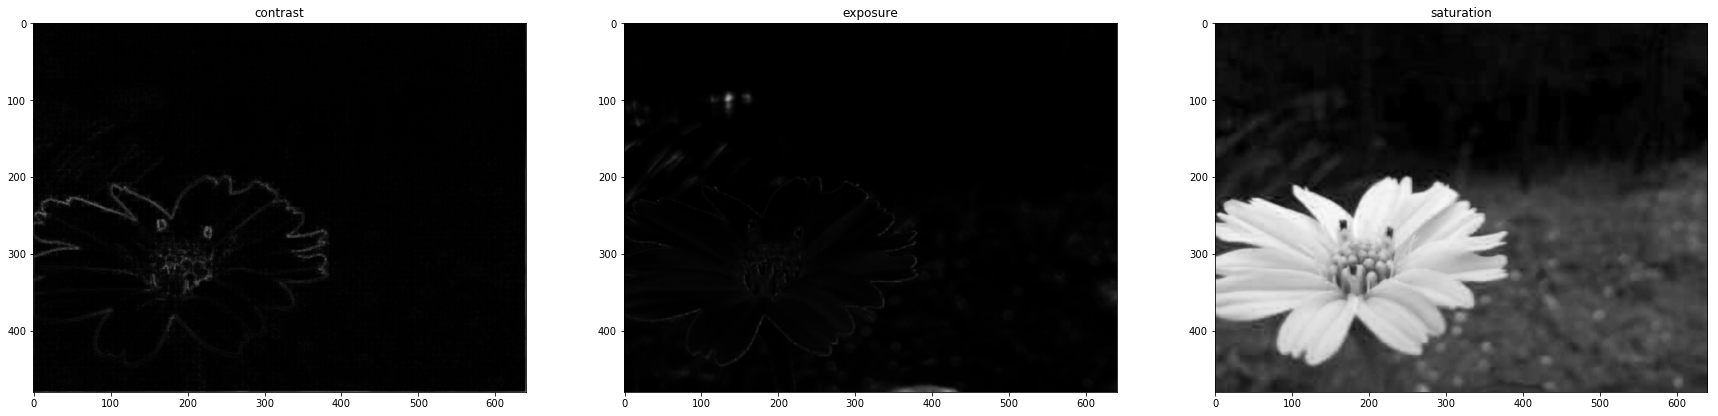

In [4]:
def weightedAverage(pixel):
    return 0.299 * pixel[0] + 0.587 * pixel[1] + 0.114 * pixel[2]

def exponential_euclidean(canal, sigma):
    return np.exp(-(canal - 0.5)**2 / (2 * sigma**2))


class Image(object):
    """Class for Image"""

    def __init__(self, fmt, path, crop=False, n=0):
        self.path = os.path.join("image_set", fmt, str(path))
        self.fmt = fmt
        self.array = plt.imread(self.path)
        self.array = self.array.astype(np.float32) / 255
        if crop:
            self.crop_image(n)
        self.shape = self.array.shape

    def crop_image(self, n):
        resolution = 2**n
        (height, width, _) = self.array.shape
        (max_height, max_width) = (resolution * (height // resolution), resolution * (width // resolution))
        (begin_height, begin_width) = (int((height - max_height) / 2), int((width - max_width) / 2))
        #print(max_height, int(begin_height), max_width, int(begin_width))
        self.array = self.array[begin_height : max_height + begin_height, begin_width:max_width + begin_width]

    @property
    def grayScale(self):
        """Grayscale image"""
        rgb = self.array
        self._grayScale = np.dot(rgb[..., :3], [0.299, 0.587, 0.114])
        return self._grayScale

    def saturation(self):
        """Function that returns the Saturation map"""
        red_canal = self.array[:, :, 0]
        green_canal = self.array[:, :, 1]
        blue_canal = self.array[:, :, 2]
        mean = (red_canal + green_canal + blue_canal) / 3.0
        saturation = np.sqrt(((red_canal - mean)**2 + (green_canal - mean)**2 + (blue_canal - mean)**2) / 3)
        #print(np.min(saturation), np.max(saturation))
        saturation = saturation - np.min(saturation)
        saturation = saturation / np.max(saturation)
        #print(np.min(saturation), np.max(saturation))
        return saturation

    def contrast(self):
        """Function that returns the Constrast numpy array"""
        grey = self.grayScale
        contrast = np.zeros((self.shape[0], self.shape[1]))
        grey_extended = np.zeros((self.shape[0] + 2, self.shape[1] + 2))
        grey_extended[1:self.shape[0] + 1, 1:self.shape[1] + 1] = grey
        kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
        for row in range(self.shape[0]):
            for col in range(self.shape[1]):
                contrast[row][col] = np.abs((kernel * grey_extended[row:(row + 3), col:(col + 3)]).sum())
        contrast = (contrast - np.min(contrast))
        contrast = contrast / np.max(contrast)
        return contrast

    def sobel(self):
        """Function that returns the Constrast numpy array"""
        grey = self.grayScale
        sobel_h = np.zeros((self.shape[0], self.shape[1]))
        sobel_v = np.zeros((self.shape[0], self.shape[1]))
        grey_extended = np.zeros((self.shape[0] + 2, self.shape[1] + 2))
        grey_extended[1:self.shape[0] + 1, 1:self.shape[1] + 1] = grey
        kernel1 = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        kernel2 = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, -1]])
        for row in range(self.shape[0]):
            for col in range(self.shape[1]):
                sobel_h[row][col] = np.abs((kernel1 * grey_extended[row:(row + 3), col:(col + 3)]).sum())
                sobel_v[row][col] = np.abs((kernel2 * grey_extended[row:(row + 3), col:(col + 3)]).sum())
        return sobel_h, sobel_v

    def exposedness(self):
        """Function that returns the Well-Exposedness map"""
        red_canal = self.array[:, :, 0]
        green_canal = self.array[:, :, 1]
        blue_canal = self.array[:, :, 2]
        sigma = 0.2
        red_exp = exponential_euclidean(red_canal, sigma)
        green_exp = exponential_euclidean(green_canal, sigma)
        blue_exp = exponential_euclidean(blue_canal, sigma)
        return red_exp * green_exp * blue_exp


im = Image("jpeg", "flower.jpeg")
contrast = im.contrast()
exposure = im.exposedness()
saturation = im.saturation()
plt.figure(figsize=(30,20))
plt.subplot(1, 3, 1)
plt.imshow(contrast, cmap = 'gray', interpolation='bicubic', vmax=1.0)
plt.title('contrast')
plt.subplot(1, 3, 2)
plt.imshow(exposure, cmap = 'gray', interpolation='bicubic', vmax=1.0)
plt.title('exposure')
plt.subplot(1, 3, 3)
plt.imshow(saturation, cmap = 'gray', interpolation='bicubic', vmax=1.0)
plt.title('saturation')
plt.show()


# laplacian fusion

## read images

In [5]:
names = [line.rstrip('\n') for line in open('list_images.txt')]
height_pyr = 6
images = []
for name in names:
    images.append(Image('mask', name, crop = True, n = height_pyr))
shape = images[0].shape
num_images = len(images)

## calc weights map

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

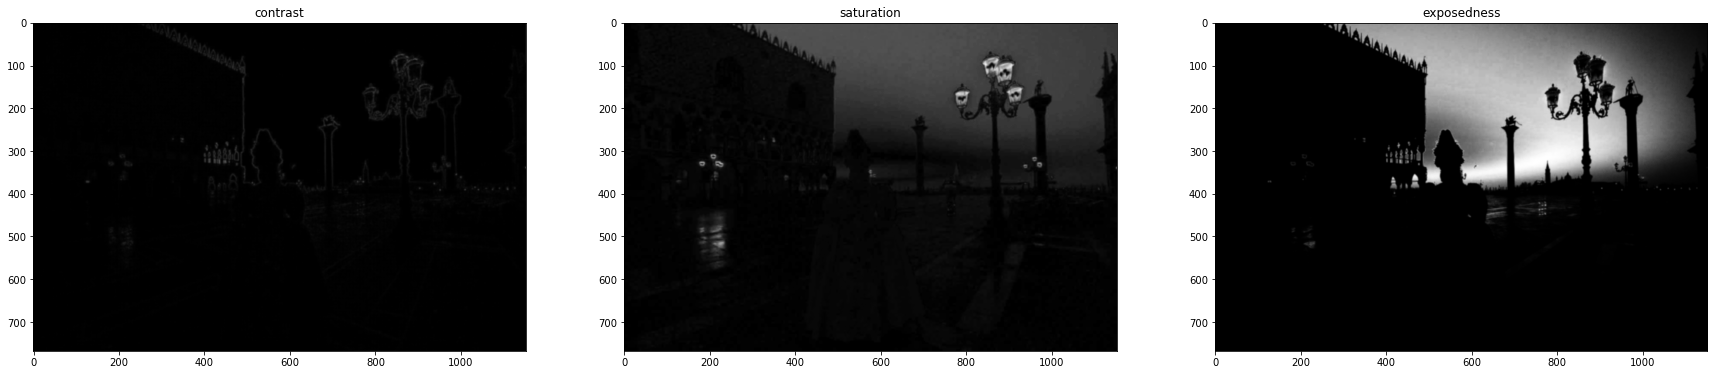

 33%|████████████████████████████                                                        | 1/3 [00:05<00:10,  5.13s/it]

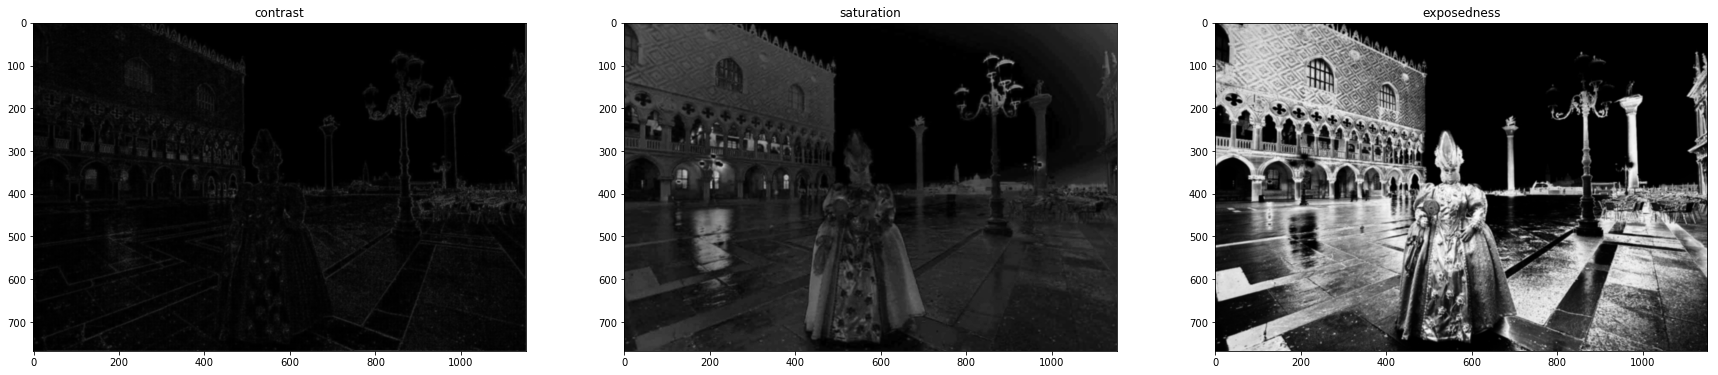

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:10<00:05,  5.17s/it]

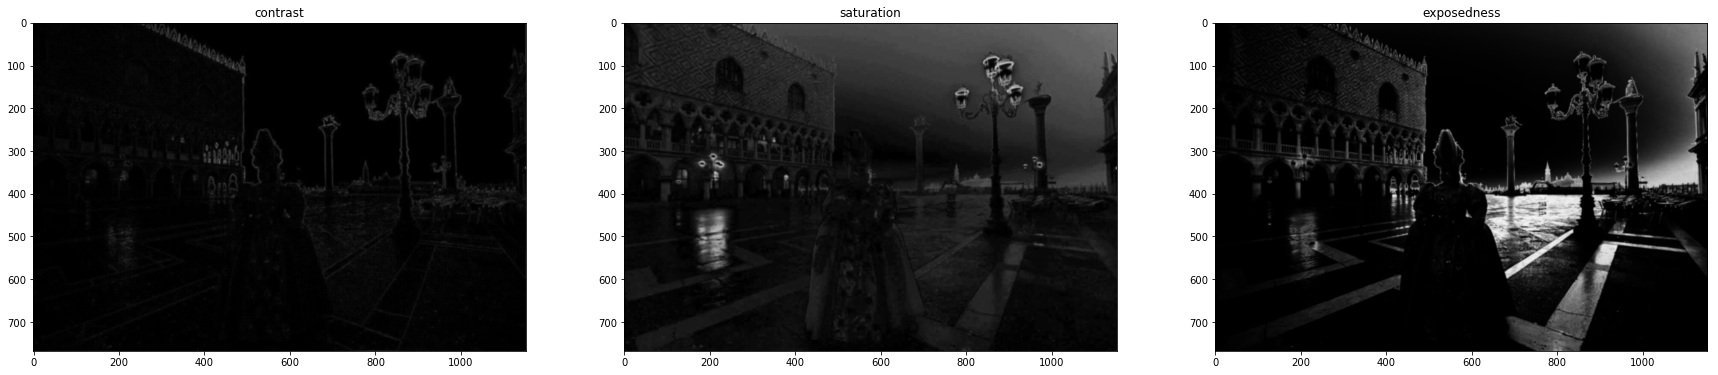

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.13s/it]


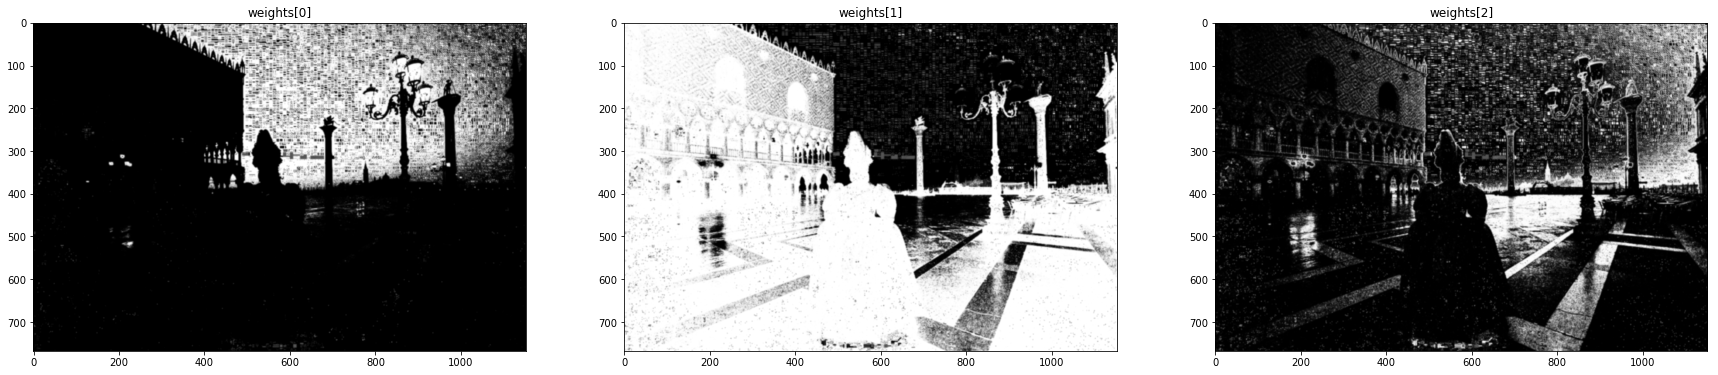

In [6]:
def get_weights_map(w_c, w_s, w_e):
    """Return the normalized Weight map"""
    weights = []
    sums = np.zeros((shape[0], shape[1]))
    for image_name in tqdm(images):
        contrast = image_name.contrast()
        #print(np.max(contrast), np.min(contrast))
        saturation = image_name.saturation()
        #print(np.max(saturation), np.min(saturation))
        exposedness = image_name.exposedness()
        #print(np.max(exposedness), np.min(exposedness))
        weight = (contrast**w_c) * (saturation**w_s) * (exposedness**w_e) + 1e-12
        weights.append(weight)
        sums = sums + weight
        
        plt.figure(figsize=(30,20))
        plt.subplot(1, 3, 1)
        plt.imshow(contrast, cmap = 'gray', interpolation='bicubic', vmax=1.0)
        plt.title('contrast')
        plt.subplot(1, 3, 2)
        plt.imshow(saturation, cmap = 'gray', interpolation='bicubic', vmax=1.0)
        plt.title('saturation')
        plt.subplot(1, 3, 3)
        plt.imshow(exposedness, cmap = 'gray', interpolation='bicubic', vmax=1.0)
        plt.title('exposedness')
        plt.show()
        
    for index in range(num_images):
        weights[index] = weights[index] / sums
        
    plt.figure(figsize=(30,20))
    plt.subplot(1, 3, 1)
    plt.imshow(weights[0], cmap = 'gray', interpolation='bicubic', vmax=1.0)
    plt.title('weights[0]')
    plt.subplot(1, 3, 2)
    plt.imshow(weights[1], cmap = 'gray', interpolation='bicubic', vmax=1.0)
    plt.title('weights[1]')
    plt.subplot(1, 3, 3)
    plt.imshow(weights[2], cmap = 'gray', interpolation='bicubic', vmax=1.0)
    plt.title('weights[2]')
    plt.show()
        
    return weights

weights = get_weights_map(w_c=1, w_s=1, w_e=1)
#print(weights.shape)

## create pymarid

In [7]:
def get_gaussian_pyramid(image, n):
    """Return the Gaussian Pyramid of an image"""
    gaussian_pyramid_floors = [image]
    for floor in range(1, n):
        #print('get_gaussian_pyramid', gaussian_pyramid_floors[-1].shape)
        gaussian_pyramid_floor = Reduce(gaussian_pyramid_floors[-1], 1)
        #print(gaussian_pyramid_floors[-1].shape)
        #print(floor, gaussian_pyramid_floor.shape)
        gaussian_pyramid_floors.append(gaussian_pyramid_floor)
    return gaussian_pyramid_floors

def get_gaussian_pyramid_weights(weights):
    """Return the Gaussian Pyramid of the Weight map of all images"""
    weights_pyramid = []
    for index in tqdm(range(num_images)):
        #print(index)
        weight_pyramid_floors = get_gaussian_pyramid(weights[index], height_pyr)
        #print(len(weight_pyramid_floors))
        weights_pyramid.append(weight_pyramid_floors)
    return weights_pyramid

# print(weights)
gaussian_pyramid_weights = get_gaussian_pyramid_weights(weights)


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.36it/s]


In [28]:
def get_laplacian_pyramid(image, n):
    """Return the Laplacian Pyramid of an image"""
    # print('get_laplacian_pyramid' ,image.shape)
    gaussian_pyramid_floors = get_gaussian_pyramid(image, n)
    #print(gaussian_pyramid_floors)
    laplacian_pyramid_floors = [gaussian_pyramid_floors[-1]]
    for floor in range(n - 2, -1, -1):
        
        new_floor = gaussian_pyramid_floors[floor] - Expand(gaussian_pyramid_floors[floor + 1], 1)
        laplacian_pyramid_floors = [new_floor] + laplacian_pyramid_floors
    return laplacian_pyramid_floors

def get_laplacian_pyramid_images(images):
    """Return all the Laplacian pyramid for all images"""
    laplacian_pyramids = []
    for index in tqdm(range(len(images))):
        laplacian_pyramid = get_laplacian_pyramid(images[index].array, height_pyr)
        # print(index, len(laplacian_pyramid))
        laplacian_pyramids.append(laplacian_pyramid)
    return laplacian_pyramids

laplacian_pyramid_images = get_laplacian_pyramid_images(images)




  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.20it/s]

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s]



## fusion

('floor', 0, 'shape', (768L, 1152L, 3L))
('floor', 1, 'shape', (384L, 576L, 3L))
('floor', 2, 'shape', (192L, 288L, 3L))
('floor', 3, 'shape', (96L, 144L, 3L))
('floor', 4, 'shape', (48L, 72L, 3L))
('floor', 5, 'shape', (24L, 36L, 3L))
('floor ', 4, 'result_image.shape', (24L, 36L, 3L), 'result_pyramid[floor].shape', (48L, 72L, 3L))
('floor ', 3, 'result_image.shape', (48L, 72L, 3L), 'result_pyramid[floor].shape', (96L, 144L, 3L))
('floor ', 2, 'result_image.shape', (96L, 144L, 3L), 'result_pyramid[floor].shape', (192L, 288L, 3L))
('floor ', 1, 'result_image.shape', (192L, 288L, 3L), 'result_pyramid[floor].shape', (384L, 576L, 3L))
('floor ', 0, 'result_image.shape', (384L, 576L, 3L), 'result_pyramid[floor].shape', (768L, 1152L, 3L))


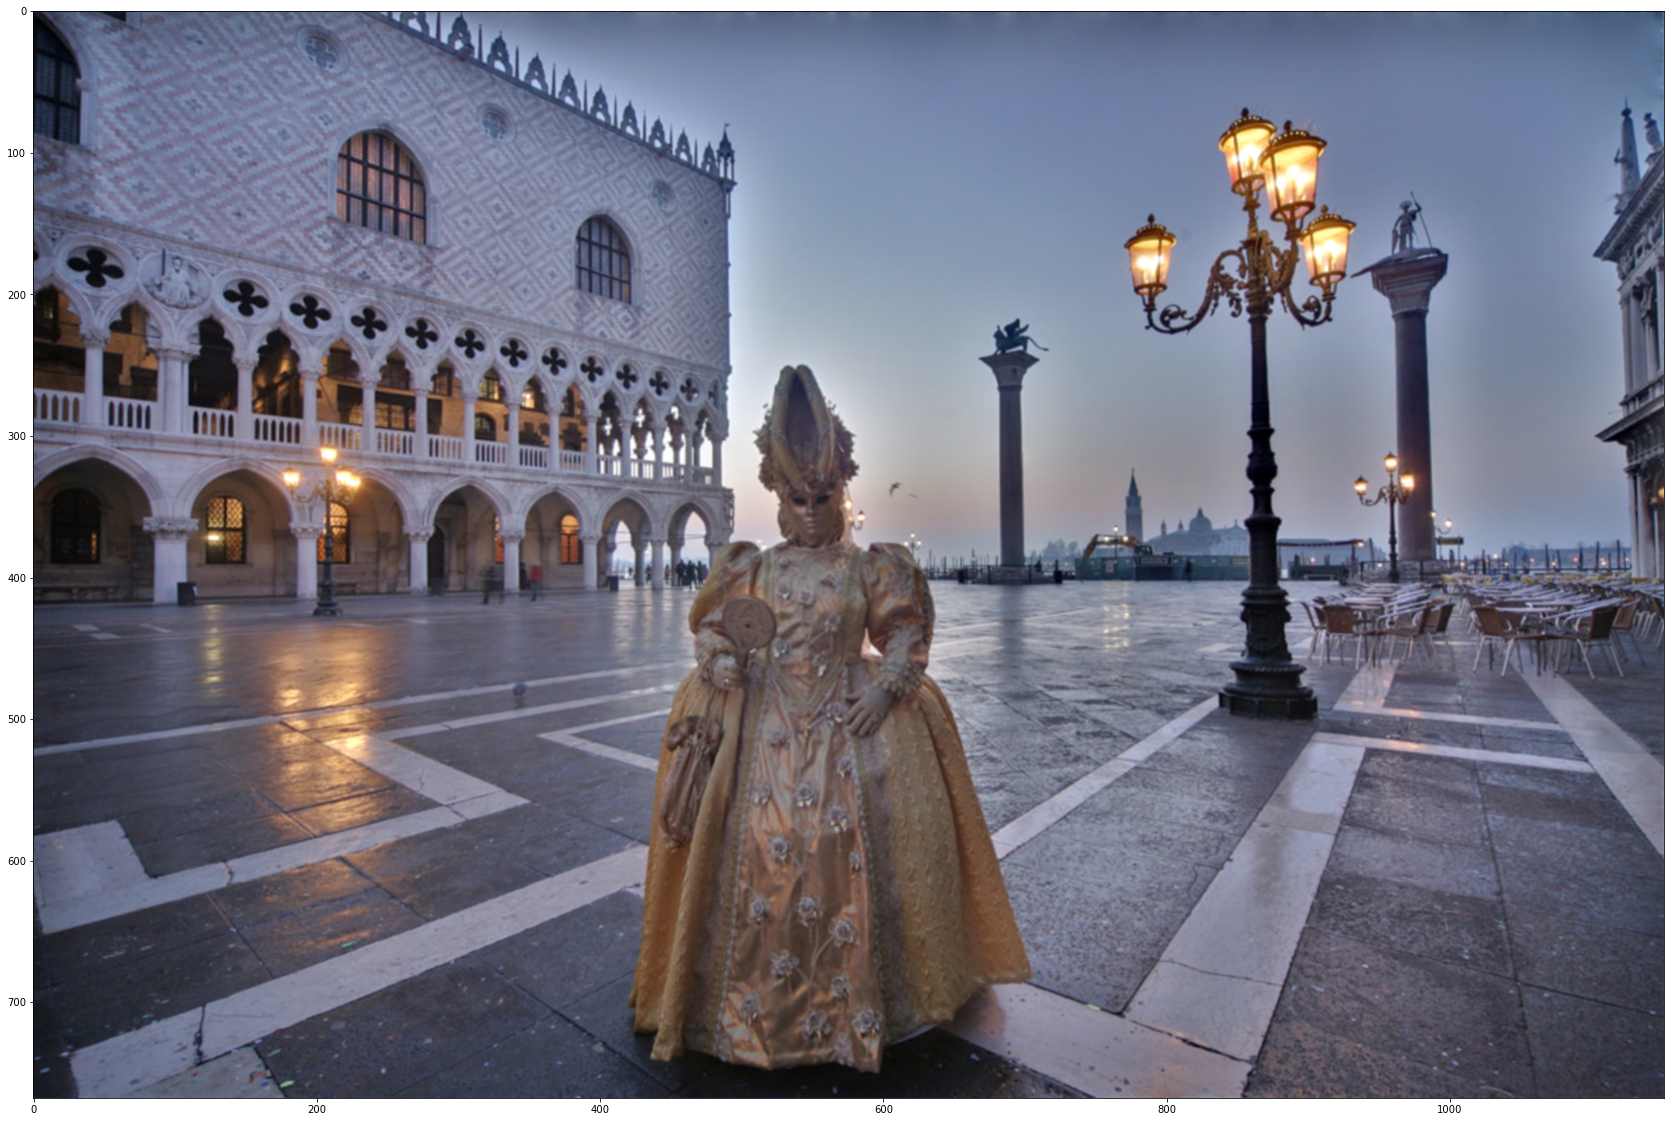

In [20]:
def result_exposure():
    "Return the Exposure Fusion image with Laplacian/Gaussian Fusion method"
    result_pyramid = []
    for floor in range(height_pyr):
        floor_shape = laplacian_pyramid_images[0][floor].shape
        result_floor = np.zeros(floor_shape)
        print('floor', floor, 'shape', floor_shape)
        for index in range(num_images):
            for canal in range(3):
                result_floor[:, :,canal] += laplacian_pyramid_images[index][floor][:, :,canal] * gaussian_pyramid_weights[index][floor]
                #result_floor[:, :] += laplacian_pyramid_images[index][floor][:, :] * gaussian_pyramid_weights[index][floor]
        result_pyramid.append(result_floor)

    # Get the image from the Laplacian pyramid
    result_image = result_pyramid[-1]
    for floor in range(height_pyr - 2, -1, -1):
        print ('floor ', floor, 'result_image.shape', result_image.shape, 'result_pyramid[floor].shape', result_pyramid[floor].shape)
        result_image = result_pyramid[floor] + Expand(result_image, 1) # expand 1 做一次2x的上采样
    result_image[result_image < 0] = 0
    result_image[result_image > 1] = 1
    return result_image

# laplacian_pyramid_images是三个图像分别做的laplacian金字塔，每个图像的金字塔有六层，每层的尺寸分别是[768L, 1152L] [384L, 576L] [192L, 288L] [96L, 144L] [96L, 144L] [48L, 72L] [24L, 36L]
# gaussian_pyramid_weights是三个图像融合权重分别做的gaussian金子谈，每个图像权重也有六层，每层的尺寸和上面是一样的，不过rgb三通道没有区分
res = result_exposure(laplacian_pyramid_images, gaussian_pyramid_weights)
plt.figure(figsize=(30,20))
plt.imshow(res, interpolation='bicubic', vmax=1.0)
plt.show()

In [25]:
image = np.ones((3,3))
image_to_expand = np.ones((6,6))
image_to_expand[::2, ::2] = image
print(image_to_expand)

[[ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.]]
